In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

In [2]:
env = gym.make('CartPole-v1')
print(env.observation_space.low, env.observation_space.high)

[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38] [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]


In [3]:
max_obs_values = np.array([2.4, 4, 0.2099 , 4])
min_obs_values = np.array([-2.4, -4, -0.2099, -4])
print(min_obs_values, max_obs_values)

[-2.4    -4.     -0.2099 -4.    ] [2.4    4.     0.2099 4.    ]


In [4]:
DISCRETE_OBS_SPACE_SIZE = [10]* len(max_obs_values) # these are the what the max values will corresponds to
discrete_obs_space_step_size = (max_obs_values - min_obs_values) / DISCRETE_OBS_SPACE_SIZE

def discretizer(obs):
    # obs = np.array([obs[0], obs[2]])
    discrete_obs = (obs - min_obs_values)/discrete_obs_space_step_size
    return tuple(discrete_obs.astype(np.int16)) # tuple to make indexing easier


In [25]:
LEARNING_RATE = 0.1
DISCOUNT = 0.99
EXPLORATION_RATE = 1
EXPLORATION_DECAY_RATE = 0.00001

In [26]:
q_table = np.zeros(DISCRETE_OBS_SPACE_SIZE + [env.action_space.n])
q_table.shape

(10, 10, 10, 10, 2)

In [27]:
print(q_table[0][0][0][0])
print(q_table[(0,0,0,0)]) 

[0. 0.]
[0. 0.]


In [28]:
observation, info = env.reset()
# obs = np.array([observation[0], observation[2]])
obs = observation
print(min_obs_values, max_obs_values)
print(obs)
discrete_obs = (obs - min_obs_values)/discrete_obs_space_step_size
discrete_obs = tuple(discrete_obs.astype(np.int16))
discrete_obs

[-2.4    -4.     -0.2099 -4.    ] [2.4    4.     0.2099 4.    ]
[-0.04593377 -0.01918283 -0.04839711 -0.01037601]


(4, 4, 3, 4)

In [55]:
total_count = 0
non_zero_count = 0
for i in range(10):
    for j in range(10):
        for k in range(10):
            for l in range(10):
                probility = q_table[(i,j,k,l)]
                if np.count_nonzero(probility) != 0:
                    # print(probility)
                    non_zero_count += 1
                total_count += 1
print(non_zero_count/total_count) # it doesn't even see most of the observation combinations
# 0.1793 max i have seen

0.1576


In [30]:
action = 1
discrete_obs = (4, 5, 1, 3)
print(q_table[discrete_obs])

# q_table[discrete_obs + (action,)]

[0. 0.]


In [31]:
scores = []

In [48]:
num_episodes = 10000
for e in range(num_episodes):
    state, _ = env.reset()
    discrete_state = discretizer(state) 
    done = False; score_per_episode = 0
    while not done:
        action = np.argmax(q_table[discrete_state])
        if EXPLORATION_RATE > np.random.random():
             action = env.action_space.sample() 
        new_state, reward, done, _, _ = env.step(action)
        new_discrete_state = discretizer(new_state)
        # print(discrete_state, action)
        if not done:
            max_future_q = np.max(q_table[new_discrete_state])
            current_q = q_table[discrete_state + (action,)]
            new_q = (1-LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
            q_table[discrete_state + (action,)] = new_q
            
        state = new_state
        discrete_state = new_discrete_state
        score_per_episode += reward
        
    EXPLORATION_RATE = max(EXPLORATION_RATE - EXPLORATION_DECAY_RATE, 0)
    scores.append(score_per_episode)
    if e % 1000 == 0:
        print(f"Episode {e}, exploration rate {EXPLORATION_RATE}, score {score_per_episode}")
    # if score_per_episode > 2000:
    #     break
        
env.close()

# cart position is not really changing much for random actions, maybe i should use all the observations


Episode 0, exploration rate 0.19999000000197548, score 72.0
Episode 1000, exploration rate 0.18999000000196548, score 51.0
Episode 2000, exploration rate 0.17999000000195547, score 423.0
Episode 3000, exploration rate 0.16999000000194547, score 30.0
Episode 4000, exploration rate 0.15999000000193547, score 49.0
Episode 5000, exploration rate 0.14999000000192547, score 15.0
Episode 6000, exploration rate 0.13999000000191547, score 75.0
Episode 7000, exploration rate 0.12999000000190547, score 20.0
Episode 8000, exploration rate 0.11999000000190242, score 25.0
Episode 9000, exploration rate 0.1099900000019063, score 197.0


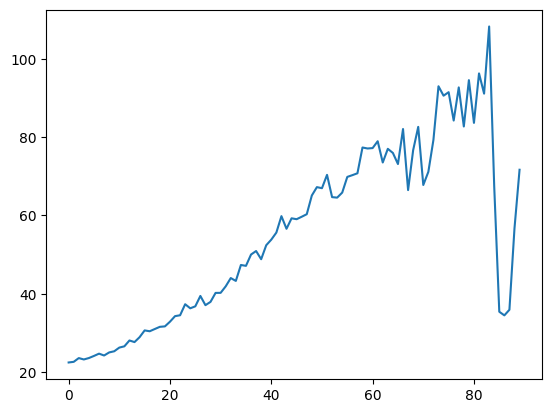

In [54]:
window_size = 1000
num_windows = len(scores) // window_size
smoothed_scores = [np.mean(scores[i*window_size:(i+1)*window_size]) for i in range(num_windows)]
plt.plot(smoothed_scores)
